In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Disease

/content/drive/MyDrive/Colab Notebooks/Disease


# Imports

In [3]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize

# Preprocessing

In [4]:
def refine(df):
   # total 4 classes, leave only original data
  df.loc[df['timestamp(day)'].isin([-5, -4]), 'timestamp(day)'] = -3
  df= df[df['original'] == 1]
  df = df.drop('original', axis = 1)
  df['timestamp(day)'] = df['timestamp(day)'].astype(int)
  df.reset_index(drop=True, inplace=True)
  
  return df

def replace_outliers_with_nan(column):
  mean = column.mean()
  std = column.std()
  threshold_up = mean + 3 * std
  threshold_down = mean - 3 * std
  column[column > threshold_up] = np.nan
  column[column < threshold_down] = np.nan

def imputation(df):
  # df array of each patient
  df_array = []
  
  # one df by one patient, make and df_array
  group_start_index = 0
  for i, row in df.iterrows():
      if row['timestamp(hr)'] == 0 and row['timestamp(day)'] == 0:
          group_df = df[group_start_index:i+1].copy()
          df_array.append(group_df)
          group_start_index = i+1

  #imputation: fill NaN values using mean value
  for df_patient in df_array:
    df_patient.fillna(df_patient.mean(), inplace=True)

  # Combine patient dataframes
  df = pd.concat(df_array)
  df.fillna(df.mean(), inplace=True) # imputation with values still with NaN
  df = df.drop('timestamp(hr)', axis = 1)
  print(df)

  return df, df_array

def normalize(df):
  # features, labels
  x = df.drop('timestamp(day)', axis=1)
  y = df['timestamp(day)']

  # Apply Minmax normalization, only normalize x
  scaler = MinMaxScaler()
  x_normalized = scaler.fit_transform(x)
  x_normalized = pd.DataFrame(x_normalized, columns=x.columns)
  y = pd.DataFrame(y, columns=['timestamp(day)'])

  return x_normalized, y

def smote(df_x, df_y):
  # Perform SMOTE to address data imbalance
  smote = SMOTE()
  x_resampled, y_resampled = smote.fit_resample(df_x, df_y)
  x_resampled = pd.DataFrame(x_resampled, columns=df_x.columns)
  y_resampled = pd.DataFrame(y_resampled, columns=df_y.columns)
  df_resampled = pd.concat([x_resampled, y_resampled], axis=1)
  return x_resampled, y_resampled, df_resampled


In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train = refine(df_train)
df_test = refine(df_test)

for col in df_train.columns:
  replace_outliers_with_nan(df_train[col])
for col in df_test.columns:
  replace_outliers_with_nan(df_test[col])


df_train, df_array_train = imputation(df_train)
df_test, df_array_test = imputation(df_test)

train_x, train_y = normalize(df_train)
test_x, test_y = normalize(df_test)


train_x, train_y, df = smote(train_x, train_y)
print(df)

<ipython-input-4-dfd6d4fdd371>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column > threshold_up] = np.nan
<ipython-input-4-dfd6d4fdd371>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column < threshold_down] = np.nan


          1     2          3           4           5          6          7  \
0       0.0  62.0  78.650000  102.095238   95.588235  20.176471  36.526667   
1       0.0  62.0  63.000000  106.000000  106.000000  19.000000  37.000000   
2       0.0  62.0  94.000000  144.000000   95.588235  20.176471  36.526667   
3       0.0  62.0  88.000000  113.000000   94.000000  15.000000  36.526667   
4       0.0  62.0  83.000000   96.000000   98.000000  20.000000  36.300000   
...     ...   ...        ...         ...         ...        ...        ...   
175509  1.0  69.0  59.618182  138.037037   49.000000  20.000000  36.200000   
175510  1.0  69.0  59.618182  138.037037   50.000000  20.000000  36.400000   
175511  1.0  69.0  74.000000  173.000000   56.269231  21.197368  36.482540   
175512  1.0  69.0  59.618182  138.037037   47.000000  20.000000  36.700000   
175513  1.0  69.0  67.000000  155.000000   46.000000  22.000000  36.400000   

            8    9     10  ...     26      27     28         29

# EDA


In [6]:
# 1) How many patients are there?
num_patients_train = len(df_array_train)
num_patients_test = len(df_array_test)
print("Number of Patients Trained: ", num_patients_train)
print("Number of Patients Test: ", num_patients_test)

# 2) What are the mean and median value of the label (day)?
label_mean = df['timestamp(day)'].mean()
label_median = df['timestamp(day)'].median()

print("Label Mean:", label_mean)
print("Label Median:", label_median)

Number of Patients Trained:  4156
Number of Patients Test:  643
Label Mean: -1.5
Label Median: -1.5



Statistics:
Column 1: Mean = 0.59, Std = 0.48
Column 2: Mean = 0.56, Std = 0.18
Column 3: Mean = 0.50, Std = 0.15
Column 4: Mean = 0.50, Std = 0.11
Column 5: Mean = 0.50, Std = 0.11
Column 6: Mean = 0.48, Std = 0.14
Column 7: Mean = 0.51, Std = 0.01
Column 8: Mean = 0.11, Std = 0.11
Column 9: Mean = 0.10, Std = 0.09
Column 10: Mean = 0.29, Std = 0.19
Column 11: Mean = 0.16, Std = 0.16
Column 12: Mean = 0.18, Std = 0.17
Column 13: Mean = 0.11, Std = 0.14
Column 14: Mean = 0.12, Std = 0.14
Column 15: Mean = 0.49, Std = 0.14
Column 16: Mean = 0.49, Std = 0.14
Column 17: Mean = 0.22, Std = 0.15
Column 18: Mean = 0.23, Std = 0.15
Column 19: Mean = 0.25, Std = 0.16
Column 20: Mean = 0.16, Std = 0.14
Column 21: Mean = 0.50, Std = 0.10
Column 22: Mean = 0.45, Std = 0.07
Column 23: Mean = 0.49, Std = 0.14
Column 24: Mean = 0.24, Std = 0.17
Column 25: Mean = 0.24, Std = 0.13
Column 26: Mean = 0.43, Std = 0.17
Column 27: Mean = 0.27, Std = 0.17
Column 28: Mean = 0.78, Std = 0.14
Column 29: Mean 

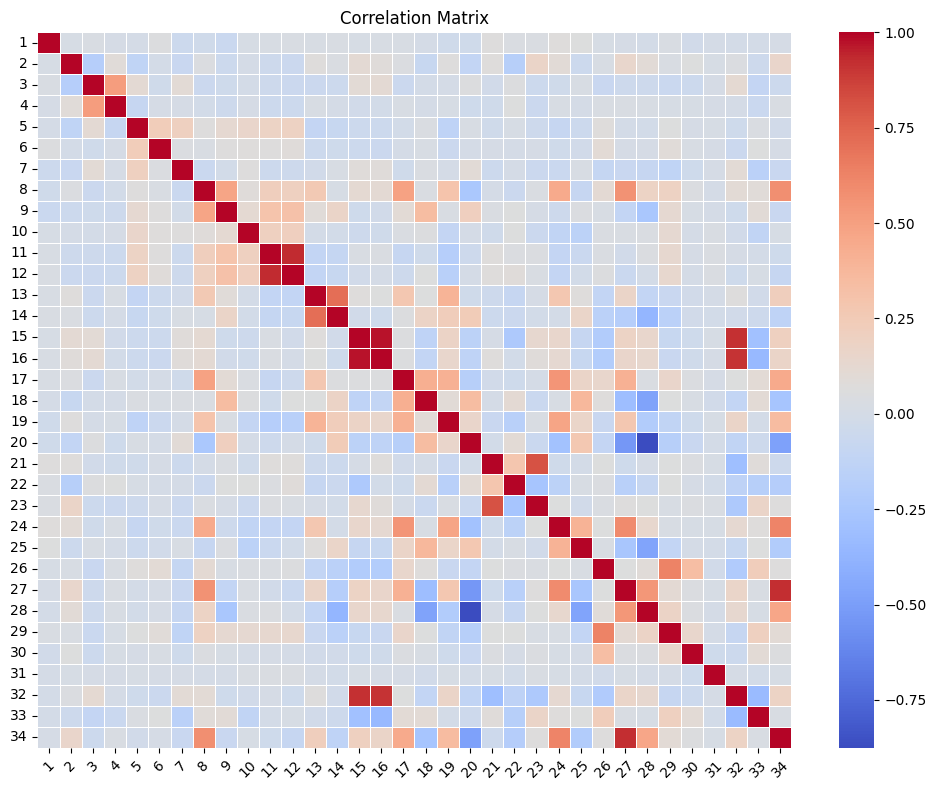

In [7]:
# 3) Perform EDA and calculate the statistics of the dataset: mean, std, correlations among features, etc.
#    (e.g.There are 34 features and you have to find the correlations among each feature (34 by 34 correlation matrix)).

selected_columns = [str(i) for i in range(1, 35)]

# statistics
means = df[selected_columns].mean()
stds = df[selected_columns].std()

print("\nStatistics:")
for column, mean, std in zip(selected_columns, means, stds):
    print(f"Column {column}: Mean = {mean:.2f}, Std = {std:.2f}")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)

# correlation matrix
correlation_matrix = df[selected_columns].corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig('correlation_matrix.png')
plt.show()

In [8]:
# 4) Explain the key insight from your observation above.
# 11, 12 / 15, 16, 32 / 27, 34 have correlation higher than 0.8, one feature can be used to represent others

# 5) Perform feature engineering/selection/importance (you may remove no more than 5 features).
#    You can employ any well-known feature engineering methods (PCA, clustering, etc.).
#    Justify your choices and processes.

remove_columns = ['12', '16', '32', '34']
df = df.drop(columns=remove_columns)
print(df.head())
train_x = train_x.drop(columns=remove_columns)
test_x = test_x.drop(columns=remove_columns)
print(train_x.head())
print(test_x.head())

     1         2         3         4         5         6         7         8  \
0  0.0  0.513158  0.651667  0.420416  0.487695  0.467870  0.498794  0.058824   
1  0.0  0.513158  0.477778  0.441989  0.540816  0.429043  0.506579  0.047059   
2  0.0  0.513158  0.822222  0.651934  0.487695  0.467870  0.498794  0.047059   
3  0.0  0.513158  0.755556  0.480663  0.479592  0.297030  0.498794  0.047059   
4  0.0  0.513158  0.700000  0.386740  0.500000  0.462046  0.495066  0.047059   

          9        10        11       13        14        15        17  \
0  0.088235  0.114504  0.158542  0.02381  0.037037  0.643646  0.215092   
1  0.058824  0.114504  0.158542  0.02381  0.034568  0.660221  0.215092   
2  0.058824  0.114504  0.158542  0.02381  0.034568  0.660221  0.215092   
3  0.058824  0.114504  0.158542  0.02381  0.034568  0.660221  0.215092   
4  0.058824  0.114504  0.158542  0.02381  0.034568  0.660221  0.215092   

         18        19        20       21        22        23        24  \


# Model Selection



In [9]:
def xgboost_model(train_x, train_y):
  model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
  model.fit(train_x, train_y)
  return model

def random_forest_model(train_x, train_y):
  model = RandomForestClassifier()
  model.fit(train_x, train_y)
  return model

def gradient_boosting_model(train_x, train_y):
  model = GradientBoostingClassifier()
  model.fit(train_x, train_y)
  return model

def logistic_regression_model(train_x, train_y):
  model = LogisticRegression(max_iter = 1000)
  model.fit(train_x, train_y)
  return model

# change label to 0,1,2,3
train_y = train_y + 3

# Split the data into train set and validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.3, random_state=42)
train_y = train_y.values.ravel()
val_y = val_y.values.ravel()

# Train models
xgb_model = xgboost_model(train_x, train_y)
rf_model = random_forest_model(train_x, train_y)
gb_model = gradient_boosting_model(train_x, train_y)
lr_model = logistic_regression_model(train_x, train_y)
# svm_model = svm_model(train_x, train_y)

# Evaluate models on validation set
xgb_pred = xgb_model.predict(val_x)
rf_pred = rf_model.predict(val_x)
gb_pred = gb_model.predict(val_x)
lr_pred = lr_model.predict(val_x)
# svm_pred = svm_model.predict(val_x)

# Compute evaluation metrics (Accuracy, Precision, Recall, F1-Score)
xgb_accuracy = accuracy_score(val_y, xgb_pred)
xgb_precision = precision_score(val_y, xgb_pred, average='macro')
xgb_recall = recall_score(val_y, xgb_pred, average='macro')
xgb_f1 = f1_score(val_y, xgb_pred, average='macro')

rf_accuracy = accuracy_score(val_y, rf_pred)
rf_precision = precision_score(val_y, rf_pred, average='macro')
rf_recall = recall_score(val_y, rf_pred, average='macro')
rf_f1 = f1_score(val_y, rf_pred, average='macro')

gb_accuracy = accuracy_score(val_y, gb_pred)
gb_precision = precision_score(val_y, gb_pred, average='macro')
gb_recall = recall_score(val_y, gb_pred, average='macro')
gb_f1 = f1_score(val_y, gb_pred, average='macro')

lr_accuracy = accuracy_score(val_y, lr_pred)
lr_precision = precision_score(val_y, lr_pred, average='macro')
lr_recall = recall_score(val_y, lr_pred, average='macro')
lr_f1 = f1_score(val_y, lr_pred, average='macro')

#Print Metrics
print("XGBoost Metrics:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1-Score (macro):", xgb_f1)

print("Random Forest Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-Score (macro):", rf_f1)

print("Gradient Boosting Metrics:")
print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1-Score (macro):", gb_f1)

print("Logistic Regression Metrics:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-Score (macro):", lr_f1)

XGBoost Metrics:
Accuracy: 0.5678317613801485
Precision: 0.5727282105441824
Recall: 0.568040669844253
F1-Score (macro): 0.5618559261411965
Random Forest Metrics:
Accuracy: 0.7860954796438667
Precision: 0.785801868362918
Recall: 0.7861431488588803
F1-Score (macro): 0.7857115547219767
Gradient Boosting Metrics:
Accuracy: 0.41889249953766083
Precision: 0.4195337443459399
Recall: 0.4193430729399594
F1-Score (macro): 0.40706142586623145
Logistic Regression Metrics:
Accuracy: 0.32366383979287205
Precision: 0.30478505860258165
Recall: 0.3241154211742141
F1-Score (macro): 0.2898835697371858


In [10]:
# Compare the performance of different models
models = {
    'XGBoost': (xgb_model, xgb_accuracy, xgb_precision, xgb_recall, xgb_f1),
    'Random Forest': (rf_model, rf_accuracy, rf_precision, rf_recall, rf_f1),
    'Gradient Boosting': (gb_model, gb_accuracy, gb_precision, gb_recall, gb_f1),
    'Logistic Regression': (lr_model, lr_accuracy, lr_precision, lr_recall, lr_f1),
}

# Find the model with the highest F1-Score
best_model = max(models, key=lambda x: models[x][4])
best_accuracy = models[best_model][1]
best_precision = models[best_model][2]
best_recall = models[best_model][3]
best_f1 = models[best_model][4]

print("\nBest Model Selection:")
print("Best Model:", best_model)
print("Accuracy:", best_accuracy)
print("Precision:", best_precision)
print("Recall:", best_recall)
print("F1-Score (macro):", best_f1)


Best Model Selection:
Best Model: Random Forest
Accuracy: 0.7860954796438667
Precision: 0.785801868362918
Recall: 0.7861431488588803
F1-Score (macro): 0.7857115547219767


# Model Tuning



In [11]:
if best_model == 'XGBoost':
  # Define the parameter grid for XGBoost
  xgb_param_grid = {
      'n_estimators': [100, 200],
      'max_depth': [3, 6],
      'learning_rate': [0.1, 0.2]
  }

  # Create the XGBoost model
  xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

  # Perform Grid Search with cross-validation
  xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=5)
  xgb_grid.fit(train_x, train_y)

  # Get the best parameters and best score from Grid Search
  best_params_xgb = xgb_grid.best_params_
  best_score_xgb = xgb_grid.best_score_

  # Get the best model from Grid Search
  best_model_xgb = xgb_grid.best_estimator_
  best_model = best_model_xgb

  # Make predictions on the validation set using the best model
  val_pred_xgb = best_model_xgb.predict(val_x)

  # Compute evaluation metrics (F1 score, Precision, Recall)
  f1_xgb = f1_score(val_y, val_pred_xgb, average='macro')
  precision_xgb = precision_score(val_y, val_pred_xgb, average='macro')
  recall_xgb = recall_score(val_y, val_pred_xgb, average='macro')

  print("Best Parameters for XGBoost:", best_params_xgb)
  print("Best Score for XGBoost:", best_score_xgb)
  print("F1 Score (macro) for XGBoost:", f1_xgb)
  print("Precision (macro) for XGBoost:", precision_xgb)
  print("Recall (macro) for XGBoost:", recall_xgb)

elif best_model == 'Random Forest':
  # Define the parameter grid for Random Forest
  rf_param_grid = {
      'n_estimators': [50, 100],
      'max_depth': [10, 20],
      'min_samples_leaf': [1, 2],
      'min_samples_split': [2, 5]
  }

  # Create the RandomForestClassifier model
  rf_model = RandomForestClassifier(random_state=42)

  # Perform Grid Search with cross-validation
  rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5)
  rf_grid.fit(train_x, train_y)

  # Get the best parameters and best score from Grid Search
  best_params_rf = rf_grid.best_params_
  best_score_rf = rf_grid.best_score_

  # Get the best model from Grid Search
  best_model_rf = rf_grid.best_estimator_
  best_model = best_model_rf

  # Make predictions on the validation set using the best model
  val_pred_rf = best_model_rf.predict(val_x)

  # Compute evaluation metrics (F1 score, Precision, Recall)
  f1_rf = f1_score(val_y, val_pred_rf, average='macro')
  precision_rf = precision_score(val_y, val_pred_rf, average='macro')
  recall_rf = recall_score(val_y, val_pred_rf, average='macro')

  print("Best Parameters for Random Forest:", best_params_rf)
  print("Best Score for Random Forest:", best_score_rf)
  print("F1 Score (macro) for Random Forest:", f1_rf)
  print("Precision (macro) for Random Forest:", precision_rf)
  print("Recall (macro) for Random Forest:", recall_rf)

elif best_model == 'Gradient Boosting':
  # Define the parameter grid for Gradient Boosting
  gb_param_grid = {
      'n_estimators': [100, 200],
      'max_depth': [3, 6],
      'learning_rate': [0.1, 0.2]
  }

  # Create the Gradient Boosting model
  gb_model = GradientBoostingClassifier()

  # Perform Grid Search with cross-validation
  gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=5)
  gb_grid.fit(train_x, train_y)

  # Get the best parameters and best score from Grid Search
  best_params_gb = gb_grid.best_params_
  best_score_gb = gb_grid.best_score_

  # Get the best model from Grid Search
  best_model_gb = gb_grid.best_estimator_
  best_model = best_model_gb

  # Make predictions on the validation set using the best model
  val_pred_gb = best_model_gb.predict(val_x)

  # Compute evaluation metrics (F1 score, Precision, Recall)
  f1_gb = f1_score(val_y, val_pred_gb, average='macro')
  precision_gb = precision_score(val_y, val_pred_gb, average='macro')
  recall_gb = recall_score(val_y, val_pred_gb, average='macro')

  print("Best Parameters for Gradient Boosting:", best_params_gb)
  print("Best Score for Gradient Boosting:", best_score_gb)
  print("F1 Score (macro) for Gradient Boosting:", f1_gb)
  print("Precision (macro) for Gradient Boosting:", precision_gb)
  print("Recall (macro) for Gradient Boosting:", recall_gb)

elif best_model == 'Logistic Regression':
  # Define the parameter grid for Logistic Regression
  lr_param_grid = {
      'C': [0.1, 1, 10],
      'solver': ['liblinear', 'saga']
  }

  # Create the Logistic Regression model
  lr_model = LogisticRegression(max_iter=1000)

  # Perform Grid Search with cross-validation
  lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=5)
  lr_grid.fit(train_x, train_y)

  # Get the best parameters and best score from Grid Search
  best_params_lr = lr_grid.best_params_
  best_score_lr = lr_grid.best_score_

  # Get the best model from Grid Search
  best_model_lr = lr_grid.best_estimator_
  best_model = best_model_lr

  # Make predictions on the validation set using the best model
  val_pred_lr = best_model_lr.predict(val_x)

  # Compute evaluation metrics (F1 score, Precision, Recall)
  f1_lr = f1_score(val_y, val_pred_lr, average='macro')
  precision_lr = precision_score(val_y, val_pred_lr, average='macro')
  recall_lr = recall_score(val_y, val_pred_lr, average='macro')

  print("Best Parameters for Logistic Regression:", best_params_lr)
  print("Best Score for Logistic Regression:", best_score_lr)
  print("F1 Score (macro) for Logistic Regression:", f1_lr)
  print("Precision (macro) for Logistic Regression:", precision_lr)
  print("Recall (macro) for Logistic Regression:", recall_lr)

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for Random Forest: 0.7066825969921086
F1 Score (macro) for Random Forest: 0.7164263865668613
Precision (macro) for Random Forest: 0.7300769799561758
Recall (macro) for Random Forest: 0.718144354445637


# Model Evaluation / Metrics

In [12]:
test_y = test_y + 3
test_y = test_y.values.ravel()

def evaluation(model):
  # Make predictions on the test set using the best model
  test_pred = model.predict(test_x)

  # Compute evaluation metrics (Accuracy, F1 score, Precision, Recall) on the test set
  test_accuracy = accuracy_score(test_y, test_pred)
  test_f1 = f1_score(test_y, test_pred, average='macro')
  test_precision = precision_score(test_y, test_pred, average='macro')
  test_recall = recall_score(test_y, test_pred, average='macro')

  print("Test Results:")
  print("Accuracy on the test set:", test_accuracy)
  print("F1 Score (macro) on the test set:", test_f1)
  print("Precision (macro) on the test set:", test_precision)
  print("Recall (macro) on the test set:", test_recall)

  # Define the class labels
  classes = [0, 1, 2, 3]  # Update with your class labels

  # Define the class names for visualization
  class_names = [-3, -2, -1, 0]  # Update with the desired class names

  # Compute the confusion matrix
  cm = confusion_matrix(test_y, test_pred)

  # Create a DataFrame for the confusion matrix
  cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

  # Plot the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

  # Convert the test labels into binary format (one-vs-all)
  binarized_test_y = label_binarize(test_y, classes=classes)

  # Compute the predicted probabilities for each class
  test_prob = best_model.predict_proba(test_x)

  # Compute the false positive rate, true positive rate, and threshold for each class
  fpr = dict()
  tpr = dict()
  thresholds = dict()
  roc_auc = dict()

  for i in range(len(classes)):
      fpr[i], tpr[i], thresholds[i] = roc_curve(binarized_test_y[:, i], test_prob[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot the ROC curve for each class
  plt.figure()
  colors = ['b', 'g', 'r', 'c']  # Update with desired colors
  class_names = ['-3', '-2', '-1', '0']  # Update with desired class names
  for i in range(len(classes)):
      plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='Class %s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))

  # Add labels and legend
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()


Test Results:
Accuracy on the test set: 0.44381642808871413
F1 Score (macro) on the test set: 0.2487426150770108
Precision (macro) on the test set: 0.2943263340596542
Recall (macro) on the test set: 0.2722334094342852


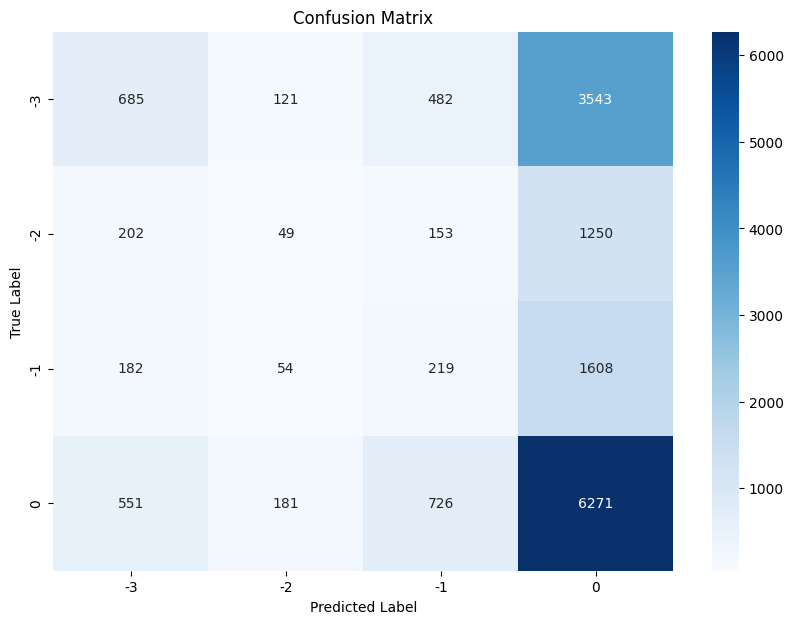

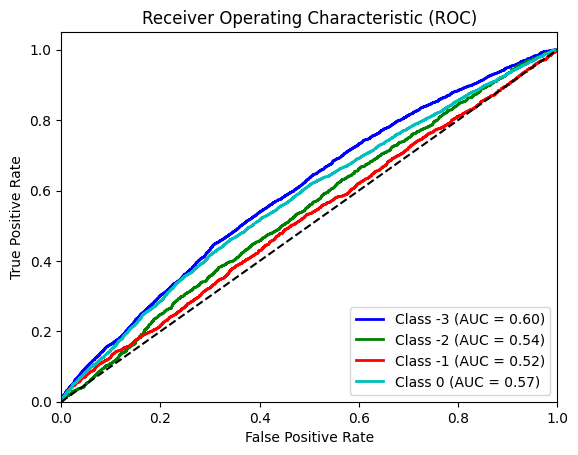

In [13]:
evaluation(best_model)


Test Results:
Accuracy on the test set: 0.34637832524420964
F1 Score (macro) on the test set: 0.2382000349037862
Precision (macro) on the test set: 0.28416350475177926
Recall (macro) on the test set: 0.27057858367182414


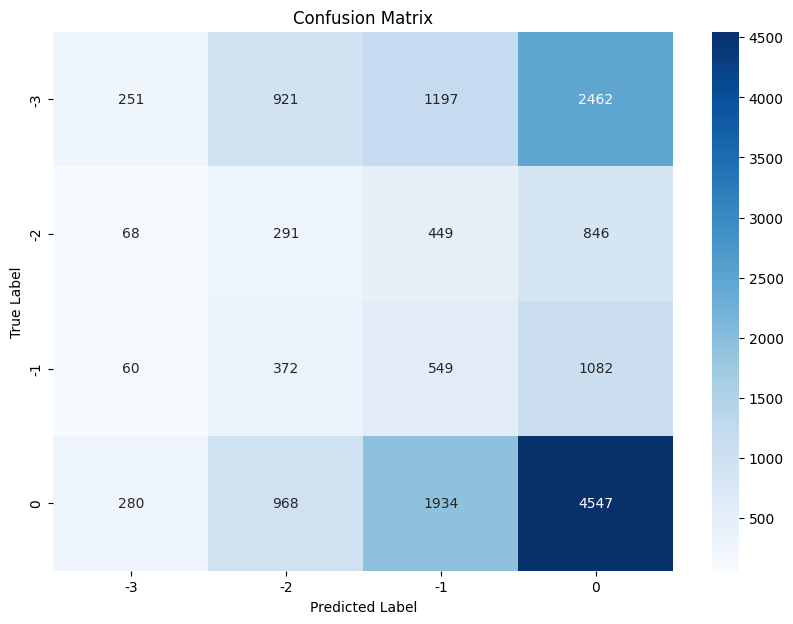

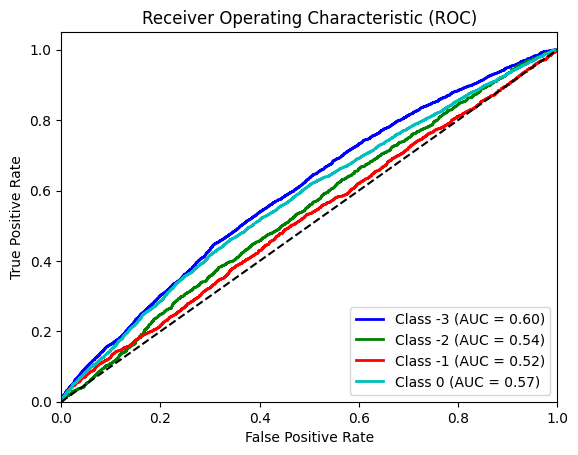

In [14]:
evaluation(xgb_model)

Test Results:
Accuracy on the test set: 0.34066474166001104
F1 Score (macro) on the test set: 0.2552026558400099
Precision (macro) on the test set: 0.30049132251158794
Recall (macro) on the test set: 0.2789950460805424


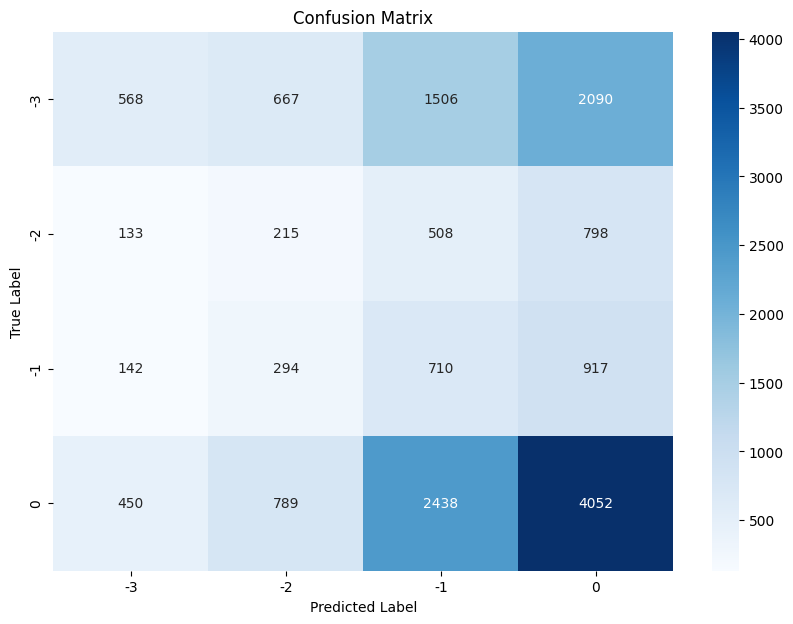

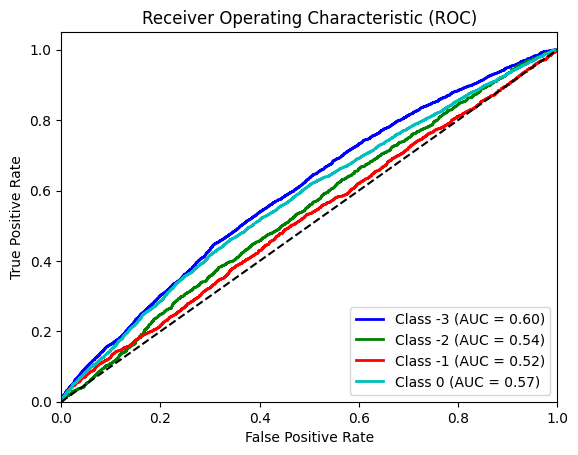

In [15]:
evaluation(gb_model)

Test Results:
Accuracy on the test set: 0.281010014130368
F1 Score (macro) on the test set: 0.26280437808110035
Precision (macro) on the test set: 0.29477273013474037
Recall (macro) on the test set: 0.2947892951677435


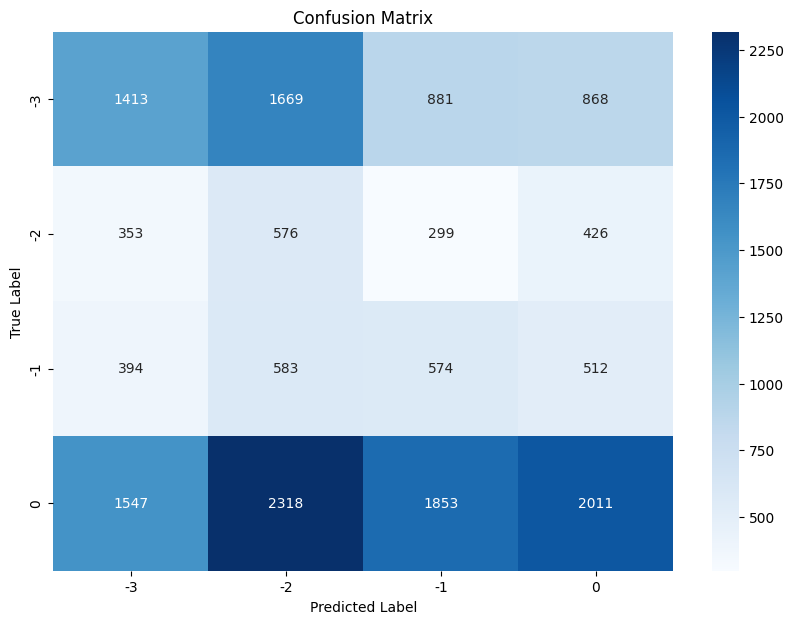

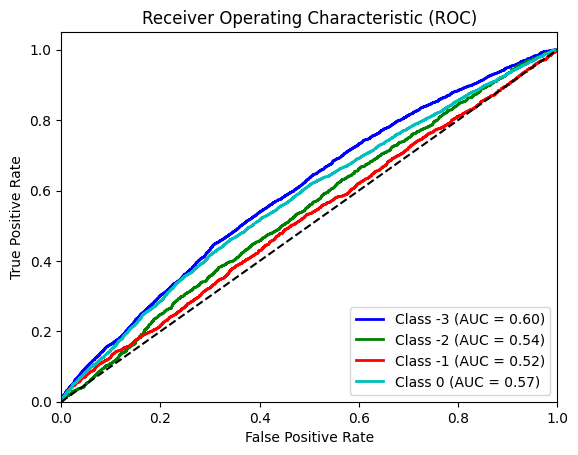

In [16]:
evaluation(lr_model)

Test Results:
Accuracy on the test set: 0.44559808318486205
F1 Score (macro) on the test set: 0.24096036070499877
Precision (macro) on the test set: 0.2978326330164229
Recall (macro) on the test set: 0.26984082121611863


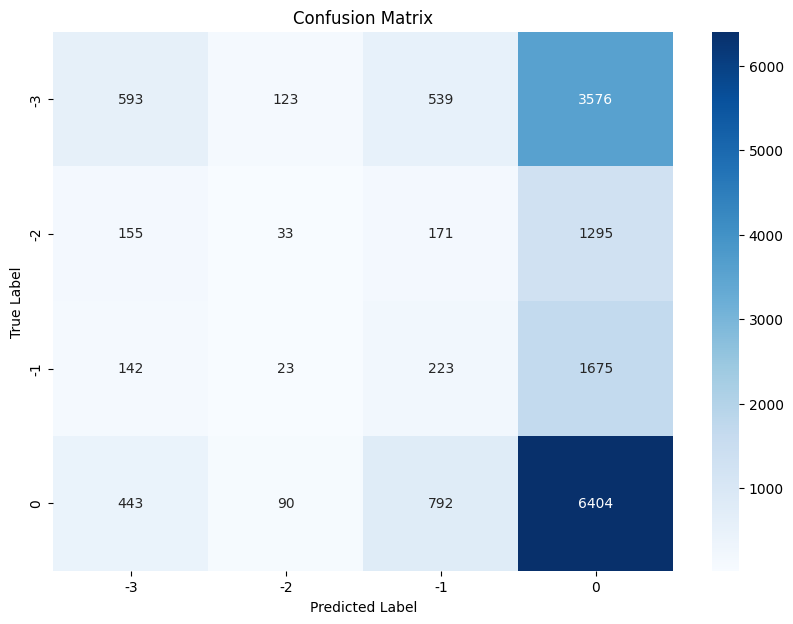

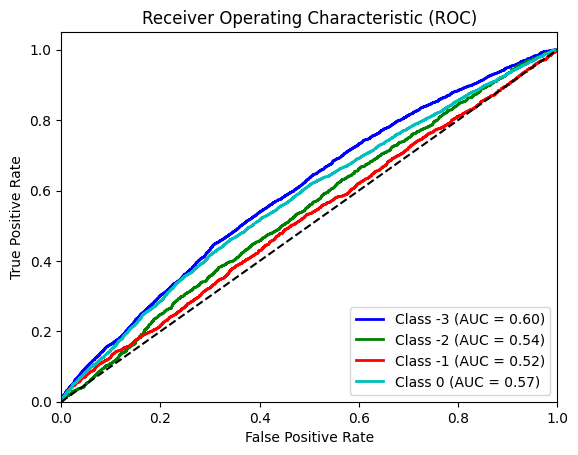

In [18]:
evaluation(random_forest_model(train_x, train_y))